In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import corner

# 11a: MCMC

## Parameter uncertainty with MCMC

So we can now do MC simulations. We understand this really just means simulate many times. So what is MCMC and how is it different?

**MCMC is a form of MC but not all MCs are MCMCs!**

What is so special about MCMC?

MCMC displays the $\textit{Markov property}$: the next state just depends on the current one (think snakes and ladders!).

MCMC's are a Markov process.

$P(x_{n+1})$ depends only on $P(x_{n})$.

Markov chains are useful because of their 'stationary distribution'. Let's work through an example to work out what that means.

You have three goldfish bowls; A, B and C.
 - The pipes between them have different opening sizes so where we move next has different probabilities.
    - The fish might even stay in the same bowl
 - The goldfish doesn't remember where they were before, so they may choose to stay or move at any point
 - However, there is a cat sleeping by bowl B, so if the goldfish is in there, they will leave straight away

The probabilities of moving are as follows:
 - In Bowl A, the next bowl probabilities are A:0.5, B:0.2, C:0.3
 - In Bowl B, the next bowl probabilities are A:0.6, B:0 (the cat!), C:0.4
 - In Bowl C, the next bowl probabilities are A:0.3, B:0.4, C:0.3

This is an example of a 3 state system: we can be in state (bowl) A, B or C. The lines and numbers indicate the probability we will stay in this state next or move on to one of the other states. These probabilities are written out in the transition matrix below.

$$\begin{bmatrix}
0.5 & 0.2 & 0.3 \\
0.6 & 0 & 0.4 \\
0.3 & 0.4 & 0.3
\end{bmatrix}$$

Our bowls can be considered as vectors;
$$A=[1,0,0]$$
$$B=[0,1,0]$$
$$C=[0,0,1]$$

Let's say we start in bowl A, so we start from $[1,0,0]$

The probability for the next state $x$ will be:

$$P(x_{1})=
\begin{bmatrix}
1 & 0 & 0
\end{bmatrix}
\begin{bmatrix}
0.5 & 0.2 & 0.3 \\
0.6 & 0 & 0.4 \\
0.3 & 0.4 & 0.3
\end{bmatrix}
=\begin{bmatrix}
0.5 & 0.2 & 0.3
\end{bmatrix}$$

then the probability that the goldfish is in each bowl after one step is 0.5, 0.2 and 0.3 respectively, as expected.

So we move on; what is the probability that the fish will be in each bowl after two moves?

$$P(x_{2})=
\begin{bmatrix}
0.5 & 0.2 & 0.3
\end{bmatrix}
\begin{bmatrix}
0.5 & 0.2 & 0.3 \\
0.6 & 0 & 0.4 \\
0.3 & 0.4 & 0.3
\end{bmatrix}
= ... (\textrm{if you want to}) ...$$
We can carry this on until we reach an equilibrium.

To explain what this means, let's change notation so the 'transition matrix' is called $\mathbf{Q}$ and the vector multiplying it is $\vec{a}_{n}$

so

$$\vec{a}_{n}\mathbf{Q}=\vec{a}_{n+1}$$
$$\vec{a}_{n+1}\mathbf{Q}=\vec{a}_{n+2}$$

and so on.

An important property for finite state Markov chains is they will reach an $\textit{equlibrium}$ where:

$$\vec{a}_X\mathbf{Q}=\vec{a}_X$$

(this is the *eigenvector* with an *eigenvalue* of one)

Let's see this with a simulation for our goldfish being in bowls A, B, C above.

If we are going to reach an equilibrium, then no matter what starting value we give, we should converge to the same average probability of being in state A, B or C. Try this below by changing the initial state and the number of steps.

Add comments to the below code cell explaining what each part does

In [ ]:
### Try me for different starting points A, B or C and
### different numbers of steps
initial_state=np.matrix([[1,0,0]])
number_of_steps=3

transition_matrix=np.matrix([[0.5,0.2,0.3],[0.6,0,0.4],[0.3,0.4,0.3]])

def next_step(current,transition):
    next_step = np.dot(current,transition)
    return next_step

objects = ('A', 'B', 'C')
y_pos = np.arange(len(objects))
input_0=initial_state
for i in range(number_of_steps):
    input_1=next_step(input_0,transition_matrix)
    plt.bar(y_pos, np.squeeze(np.asarray(input_1)), align='center', color='red', alpha=0.1)
    input_0=input_1
plt.xticks(y_pos, objects)
plt.title('Probability of being in state A, B or C')
plt.xlabel('State')
plt.ylabel('Probability')

print("Final state: ", input_0)

What do you notice about the above plot. Hint: what do the final values add up to?

## Going back to our data from 10a and our straight line model, let's use MCMC to fit the data

A reminder of what our data looks like: (Copied from notebook 10a)

Text(0, 0.5, 'y')

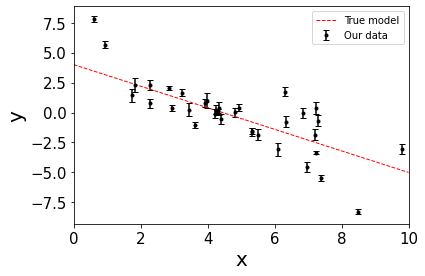

In [2]:
# Setting a seed - what does this do?
np.random.seed(123)

# The "true" parameters.
m_true = -0.9
b_true = 4.0
f_true = 0.9 

# Generate some synthetic data from the model.
N = 35 # number of data points to generate
x = np.sort(10 * np.random.rand(N)) # randomly generate x
yerr = 0.1 + 0.5 * np.random.rand(N) # randomy generate yerr
y = m_true * x + b_true # y = m*x + b
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

# plotting this data
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=3,label='Our data')

# plotting the model we drew the mock data from
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "r--", alpha=1.0, lw=1, label='True model')

# Always remember to apropriately label your plots!
plt.legend()
plt.xlim(0, 10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("x",fontsize=20)
plt.ylabel("y",fontsize=20)

### Bayes Theorem

You may have come across Bayes theorem below (think school, venn diagrams and rearranging formulae for conditional probability - if you haven't / don't remember it, wikipedia it!):

$$P(A|B) = \frac{P(A)P(B|A)}{P(B)}$$

Changing A and B into things we care about:

$$P(model | data) = \frac{P(model)P(data | model)}{P(data)}$$

The names assigned to the parts of the equations are this:

$$Posterior = \frac{Prior~\times~Likelihood}{Evidence}$$



We usually want to know what is the probability that our model is correct given the data - this is what is on the left hand side. It's name is the 'posterior' distribution.

But this can be hard to find...why?

Well... $P(model)$ (called the prior) is easy: this is just the prior information we are choosing to include.

$P(data | model)$ (called the likelihood) is usually not too hard to get the shape of the distribution. However, if we are doing this naively and evaluating the data given the model on a full grid of all possible parameters it might take forever! For example, if we have a 5 parameter model and we were to evaluate the likelihood at each of 10 values we will already have $10^{5}$ grid points!

But $P(data)$ (the evidence) is usually pretty difficult! To calculate $P(data)$ you need to have the $P(data | \textit{every hypothesis})$, this could take infinite values depending on your situation. But $P(data)$ doesn't depend on the model parameters itself. So if we can work out the shape of the final distribution we could then sample from it and use our samples to work out the probabilities.

MCMC provides us a way to sample from the distribution by creating a chain where the 'stationary' or equilibrium distribution is the same shape as the posterior distribution, but we don't need to know the exact height of this distribution.

The goal is to construct a sequence which walks around in such a way that the chain itself will have the desired stationary distribution.

One algorithm is the $\textit{metropolis hastings}$ algorithm. Let's code it up ourselves and refit our line from the start.

But first let's write some functions which will allow us to calculate the likelihood and prior.

## The likelihood

Our model is below. Let's assume this is a good model and use MCMC to find the uncertainty on the parameters.
 $$y = mx+b$$

with variance $s_n^2$

 $$
    s_n^2 = \sigma_n^2+f^2\,(m\,x_n+b)^2 \quad .
$$

This likelihood function is simply a Gaussian where the variance is
underestimated by some fractional amount,  $f$

The linear least squares method used before in the basic MC example assumed the error bars are correct, Gaussian and independent.

We know this is not the case as we set up the model. (Remember we said there was additional intrinsic scatter denoted by $f$).

Unfortunately, there isn't a generalisation of least squares that supports a model like the one that we know to be true.

We can instead write down the log (_natural log_) likelihood function and numerically maximise it. (We use the log simply because products in log are sums and that makes life easier)

In mathematical notation, the correct log likelihood function is:

$$
    \ln\,p(y\,|\,x,\sigma,m,b,f) =
    -\frac{1}{2} \sum_n \left[
        \frac{(y_n-m\,x_n-b)^2}{s_n^2}
        + \ln \left ( 2\pi\,s_n^2 \right )
    \right]
$$

where

$$
    s_n^2 = \sigma_n^2+f^2\,(m\,x_n+b)^2 \quad .
$$

This likelihood function is simply a Gaussian where the variance is
underestimated by some fractional amount:  $f$.

I have written the equation in python below but there are 4 bugs - find them!

In [ ]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta # theta contains our parameters to infer
    model = m ** x + b # our simple straight line
    sigma2 = y_err ** 2 + model ** 2 * np.exp(2 * log_f)
    ln_like = -0.5 * np.prod((y - model) ** 2 / sigma2 + np.log10(sigma2))
    return ln_like

If we drew samples from the likelihood rather than the posterior what would we be doing?

## The prior

 - What does this function below do?
    - Discuss it with each other.
 - What are the priors we are setting on our parameters?
    - Are they reasonable?
 - Add comments to the function so that you can remember this later!

In [ ]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

## The evidence

We shall ignore the evidence - it is not necessary here - if you don't remember why, go back and read the part about Bayes theorem!

## The posterior

In [ ]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

Why have we used logs above? (hint, try doing `np.exp(1000)` and `np.exp(-1000)`) What does this function do?

Now we are ready to write our MH algorithm and fit stuff with our MCMC!

## Recipe for MCMC using metropolis hastings algorithm

From the lecture:
1. Choose some random values for the parameters
2. Determine the posterior at these values
3. Propose a new step at some new values
4. Determine the posterior at these new values
5. Compare the two (divide them)
6. Generate a random number and compare this to the ratio of the posteriors to decide if you move or stay

#### Write a few functions which will perform the MH algorithm

(you should understand and comment the code)

In [ ]:
# Defines the next sample in the chain
def transition_model(theta):
    return theta_new

# Defines whether to accept or reject the new sample
def acceptance(logl, logl_new):
    return accept


def metropolis_hastings(log_probability, transition_model, param_init,iterations,x,y,yerr,acceptance_rule):
    # log_probability: posterior calculation
    # transition_model(x): gaussian proposal
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # x,y,yerr: the data that we wish to model
    # acceptance_rule(theta_prob,theta_prob_new): decides whether to accept or reject the new sample
    theta = param_init
    accepted = []
    # Can you fill me in?
    return np.array(accepted)

## Fitting the data

Using some initial starting parameters which are not the correct answer so that we can see it works!

In [3]:
m_init=m_true - m_true/1.2
b_init=b_true - b_true/1.4
f_init=f_true - f_true/1.1
print(m_true,b_true,f_true, np.log10(f_true))
print(m_init,b_init,f_init, np.log10(f_init))

-0.9 4.0 0.9 -0.045757490560675115
-0.15000000000000002 1.1428571428571428 0.0818181818181819 -1.0871501757188997


In [ ]:
theta_init = [m_init,b_init,f_init]

accepted = metropolis_hastings(
    log_probability,
    transition_model,
    theta_init,
    200000,
    x, y, yerr,
    acceptance
)

Below is some code which will visualise the results as the chain moves along for parameter b:
 - Plot it also for parameters a and f
 - What do you notice about the beginning of the chain?
 - Would you include all the samples when quoting your results for the best fit and the 1 $\sigma$ limits on the parameters?
    - Try varying the number of samples plotted in each panel

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,1,1)

parameter = 'b'
dimension = 1

n_samples = 10
ax.plot(accepted[0:n_samples,dimension], 'b.', label='Accepted',alpha=0.5)
ax.set_xlabel("Iteration", fontsize=20)
ax.set_ylabel(f"parameter {parameter}", fontsize=20)
ax.set_title(f"MCMC sampling for ${parameter}$ with Metropolis-Hastings. First {n_samples} samples are shown.", fontsize=15)
ax.grid()
ax.legend()

show_final_samples = 150
initial_sample = accepted.shape[0] - show_final_samples

ax2 = fig.add_subplot(2,1,2)
ax2.plot(np.arange(show_final_samples) + initial_sample, accepted[initial_sample:,dimension], 'b.', label='Accepted',alpha=0.5)
ax2.set_xlabel("Iteration", fontsize=20)
ax2.set_ylabel("parameter b", fontsize=20)
ax2.set_title(f"MCMC sampling for $b$ with Metropolis-Hastings, the last {show_final_samples} samples are shown.", fontsize=15)
ax2.grid()
ax2.legend()

fig.tight_layout()

Let's use a corner plot to explore our results

In [ ]:
# This is the number of samples to discard at the start of the MCMC
samples_start = 0

mh_samples = np.array([accepted[samples_start:,0],accepted[samples_start:,1],accepted[samples_start:,2]]).T
labels = ["m", "b", "log(f)"]
fig = corner.corner(mh_samples, labels=labels, truths=[m_true,b_true,np.log(f_true)], quantiles=[0.16, 0.5, 0.84], levels=(1-np.exp(-0.5),), show_titles=True, title_kwargs={"fontsize": 15}, smooth=True)


Another way to visualise this would be to plot samples from your distribution of parameters over the top of your data. For example see the code below.

In [ ]:
# So it's not too much on the plot, we will only plot 100 lines:
inds = np.random.randint(len(mh_samples), size=100)
for ind in inds:
    sample = mh_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1) # look up the vander function and see what it is doing here
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, label='data')
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.plot([],[], 'C1', label='samples')
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20);